# 개요
- 출처
  - 원본 데이터 셋
    - [Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)
  - 경진 대회 데이터 셋
    - [Paris Housing Price](https://www.kaggle.com/competitions/playground-series-s3e6/overview) 
- 개요 
  - 세계보건기구(WHO)에 따르면 뇌졸중은 전체 사망자의 약 11%를 차지하는 세계 2위의 사망 원인이다. 
  - 이 데이터 세트는 성별, 나이, 다양한 질병 및 흡연 상태와 같은 입력 매개 변수를 기반으로 환자가 뇌졸중에 걸릴 가능성이 있는지 예측 
  - 각 행은 환자에 대한 관련 정보를 제공한다.
- 평가지표 : ROC Curve
- 타임라인 : 2023.1.10 ~ 2023.1.16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_curve
from scipy import sparse
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [ ]:
# 데이터 가져오기 
data_path = '/content/drive/MyDrive/모듈프젝2/B팀-분류/data/playground-series-season-3-episode-2/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id') 
origin = pd.read_csv(data_path + 'healthcare-dataset-stroke-data.csv', index_col='id')

origin.shape, train.shape, test.shape, submission.shape

((5110, 11), (15304, 11), (10204, 10), (10204, 1))

In [ ]:
# original train, test, submission 열 확인
origin.columns, train.columns, test.columns, submission.columns

(Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
        'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
        'smoking_status', 'stroke'],
       dtype='object'),
 Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
        'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
        'smoking_status', 'stroke'],
       dtype='object'),
 Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
        'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
        'smoking_status'],
       dtype='object'),
 Index(['stroke'], dtype='object'))

```
< 각 열에 대한 정보 확인 >

'id', : 고유 ID -> 확인 결과 id 컬럼은 인덱스와 같은 의미
'gender', : Male, Female, other로 구성됨 -> 범주형(명목형)
'age', : 나이 / 수치형
'hypertension',  : 고혈압 유무 / 0 : 무, 1 : 유 => 범주형(이진형)
'heart_disease', : 심장질환 유무 / 0 : 무, 1 : 유 => 범주형(이진형)
'ever_married', : 결혼 유무 / Y : 기혼, N : 미혼 => 범주형(이진형)
'work_type', : 업무형태 / 'Private', 'children', 'Govt_job', 'Self-employed', 'Never_worked' => 범주형(명목형)
'Residence_type', : 거주지 유형 /  Urban, Rural / 도시, 시골 => 범주형(이진)
'avg_glucose_level', 평균 당 수치 / 수치형 
'bmi', : 비만도 / 수치형
'smoking_status', : 흡연상태  / 'never smoked', 'formerly smoked', 'Unknown', 'smokes' => 범주형(명목형)
'stroke' : 뇌졸중 유무 / 0 : 무, 1 : 유  => 정답(target)

```






In [ ]:
train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
15299,Female,22.0,0,0,No,Govt_job,Urban,72.63,19.5,never smoked,0
15300,Female,46.0,1,0,Yes,Private,Urban,101.19,32.1,never smoked,0
15301,Female,75.0,0,0,Yes,Self-employed,Urban,87.69,26.2,never smoked,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15304 entries, 0 to 15303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15304 non-null  object 
 1   age                15304 non-null  float64
 2   hypertension       15304 non-null  int64  
 3   heart_disease      15304 non-null  int64  
 4   ever_married       15304 non-null  object 
 5   work_type          15304 non-null  object 
 6   Residence_type     15304 non-null  object 
 7   avg_glucose_level  15304 non-null  float64
 8   bmi                15304 non-null  float64
 9   smoking_status     15304 non-null  object 
 10  stroke             15304 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.4+ MB


In [ ]:
test

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown
15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown
15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes
15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes
...,...,...,...,...,...,...,...,...,...,...
25503,Female,27.0,0,0,No,Private,Urban,75.77,17.6,never smoked
25504,Male,49.0,0,0,Yes,Private,Urban,102.91,26.7,Unknown
25505,Female,3.0,0,0,No,children,Rural,104.04,18.3,Unknown


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10204 entries, 15304 to 25507
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             10204 non-null  object 
 1   age                10204 non-null  float64
 2   hypertension       10204 non-null  int64  
 3   heart_disease      10204 non-null  int64  
 4   ever_married       10204 non-null  object 
 5   work_type          10204 non-null  object 
 6   Residence_type     10204 non-null  object 
 7   avg_glucose_level  10204 non-null  float64
 8   bmi                10204 non-null  float64
 9   smoking_status     10204 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 876.9+ KB


In [ ]:
origin

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [ ]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [ ]:
submission

,stroke
id,
15304,0.041296
15305,0.041296
15306,0.041296
15307,0.041296
15308,0.041296
...,...
25503,0.041296
25504,0.041296
25505,0.041296


# 초기 파악



## 결측치 확인

In [ ]:
# original 결측값 확인됨
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 비율로 확인
def null_per(df):
    return (df.isnull().sum() / len(df)*100).sort_values(ascending=False)

plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Original Dataset", "Training Dataset","Test Dataset"))

null_per_origin = null_per(origin)
null_per_train = null_per(train)
null_per_test = null_per(test)

print(null_per_origin)
fig.add_trace(
    go.Bar(x=null_per_origin.index, y=null_per_origin.values),
    row=1, col=1
)

print(null_per_train)

fig.add_trace(
    go.Bar(x=null_per_train.index, y=null_per_train.values),
    row=1, col=2
)

print(null_per_test)

fig.add_trace(
    go.Bar(x=null_per_test.index, y=null_per_test.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# null값 비율 확인 시 original 데이터의 bmi열에서 결측치가 존재 -> 제거 or 중간값, 평균값으로 대체 필요

bmi                  3.933464
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
smoking_status       0.000000
stroke               0.000000
dtype: float64
gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64
gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
dtype: float64


<Figure size 432x288 with 0 Axes>

## 고유값 확인

In [ ]:
plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Unique values For Original Dataset", "For Training Dataset","For Test Dataset"))

temp_data= origin.nunique().sort_values()
print(temp_data)
fig.add_trace(
    go.Bar(x=temp_data.index, y=temp_data.values),
    row=1, col=1
)

temp2_data= train.nunique().sort_values()
print(temp2_data)

fig.add_trace(
    go.Bar(x=temp2_data.index, y=temp2_data.values),
    row=1, col=2
)

temp3_data= test.nunique().sort_values()
print(temp3_data)

fig.add_trace(
    go.Bar(x=temp3_data.index, y=temp3_data.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# 이진형 : hypertension, heart_disease, ever_married, Residence_type, stroke
# 범주형 : gender, smoking_status, work_type
# 수치형 : age, bmi, avg_glucose_level 

hypertension            2
heart_disease           2
ever_married            2
Residence_type          2
stroke                  2
gender                  3
smoking_status          4
work_type               5
age                   104
bmi                   418
avg_glucose_level    3979
dtype: int64
hypertension            2
heart_disease           2
ever_married            2
Residence_type          2
stroke                  2
gender                  3
smoking_status          4
work_type               5
age                   106
bmi                   407
avg_glucose_level    3740
dtype: int64
hypertension            2
heart_disease           2
ever_married            2
Residence_type          2
gender                  3
smoking_status          4
work_type               5
age                   106
bmi                   400
avg_glucose_level    3265
dtype: int64


<Figure size 432x288 with 0 Axes>

## 중복값 확인

In [ ]:
train.shape, train.drop_duplicates().shape

((15304, 11), (15304, 11))

In [ ]:
test.shape, test.drop_duplicates().shape

((10204, 10), (10204, 10))

In [ ]:
origin.shape, origin.drop_duplicates().shape

((5110, 11), (5110, 11))

## 전체 요약

In [ ]:
def summary(df):
    print(f'data shape: {df.shape}')
    sum_df = pd.DataFrame(df.dtypes, columns=['type'])
    sum_df['null'] = df.isnull().sum().values * 100
    #sum_df['missing_per'] = df.isnull().sum().values / len(df)
    sum_df['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    sum_df['min'] = desc['min'].values
    sum_df['max'] = desc['max'].values
    sum_df['mean'] = desc['mean'].values
    sum_df['first value'] = df.iloc[0].values
    sum_df['second value'] = df.iloc[1].values
    sum_df['third value'] = df.iloc[2].values
    
    return sum_df
    
summary_df = summary(train)
summary_df

data shape: (15304, 11)


,type,null,unique,min,max,mean,first value,second value,third value
gender,object,0,3,NaN,NaN,NaN,Male,Male,Female
age,float64,0,106,0.08,82.0,41.417708,28.0,33.0,42.0
hypertension,int64,0,2,0.0,1.0,0.049726,0,0,0
heart_disease,int64,0,2,0.0,1.0,0.023327,0,0,0
ever_married,object,0,2,NaN,NaN,NaN,Yes,Yes,Yes
work_type,object,0,5,NaN,NaN,NaN,Private,Private,Private
Residence_type,object,0,2,NaN,NaN,NaN,Urban,Rural,Rural
avg_glucose_level,float64,0,3740,55.22,267.6,89.039853,79.53,78.44,103.0
bmi,float64,0,407,10.3,80.1,28.112721,31.1,23.9,40.3
smoking_status,object,0,4,NaN,NaN,NaN,never smoked,formerly smoked,Unknown


In [ ]:
summary_df2 = summary(origin)
summary_df2

data shape: (5110, 11)


,type,null,unique,min,max,mean,first value,second value,third value
gender,object,0,3,NaN,NaN,NaN,Male,Female,Male
age,float64,0,104,0.08,82.0,43.226614,67.0,61.0,80.0
hypertension,int64,0,2,0.0,1.0,0.097456,0,0,0
heart_disease,int64,0,2,0.0,1.0,0.054012,1,0,1
ever_married,object,0,2,NaN,NaN,NaN,Yes,Yes,Yes
work_type,object,0,5,NaN,NaN,NaN,Private,Self-employed,Private
Residence_type,object,0,2,NaN,NaN,NaN,Urban,Rural,Rural
avg_glucose_level,float64,0,3979,55.12,271.74,106.147677,228.69,202.21,105.92
bmi,float64,20100,418,10.3,97.6,28.893237,36.6,NaN,32.5
smoking_status,object,0,4,NaN,NaN,NaN,formerly smoked,never smoked,never smoked


In [ ]:
summary_df3 = summary(test)
summary_df3

data shape: (10204, 10)


,type,null,unique,min,max,mean,first value,second value,third value
gender,object,0,3,NaN,NaN,NaN,Female,Male,Female
age,float64,0,106,0.08,82.0,41.920713,57.0,70.0,5.0
hypertension,int64,0,2,0.0,1.0,0.05145,0,1,0
heart_disease,int64,0,2,0.0,1.0,0.021756,0,0,0
ever_married,object,0,2,NaN,NaN,NaN,Yes,Yes,No
work_type,object,0,5,NaN,NaN,NaN,Private,Private,children
Residence_type,object,0,2,NaN,NaN,NaN,Rural,Urban,Urban
avg_glucose_level,float64,0,3265,55.12,267.6,89.197766,82.54,72.06,103.72
bmi,float64,0,400,11.5,97.6,28.242351,33.4,28.5,19.5
smoking_status,object,0,4,NaN,NaN,NaN,Unknown,Unknown,Unknown


# EDA

## Target 분포 확인

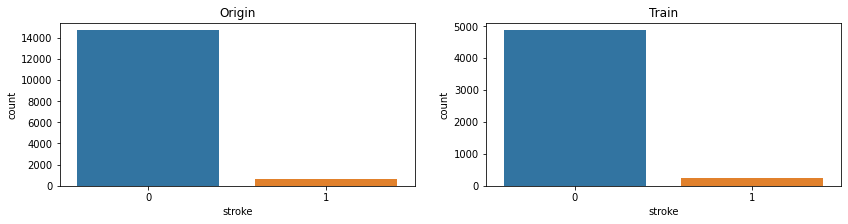

In [ ]:
plt.figure(figsize=(14,3))
ax1 = plt.subplot(1,2,1)
sns.countplot(data=train, x='stroke');
plt.title('Origin')
ax2 = plt.subplot(1,2,2)
sns.countplot(data=origin, x='stroke');
plt.title('Train')
plt.show()
# 뇌졸중을 가진 사람보다 뇌졸중이 아닌 사람이 훨씬 많음 -> 데이터 불균형함 -> train/test 시 startify = y 설정 또는 startify-fold로 모델 평가 진행

## 피처 요약 기준 해석 및 전략 수립

- 수치형
  - age
  - avg_glucose_level
  - bmi


In [ ]:
# 수치형, 범주형, 명목형 분류

# 수치형
num_cols = ['age', 'avg_glucose_level', 'bmi'] 

# 범주형
cat_cols = ['gender', 'hypertension','heart_disease','ever_married','work_type', 'Residence_type', 'smoking_status'] 

# 명목형을 고유값 개수에 따라 세부 분류함
cat_cols_v0 = ['gender'] # gender만 따로 진행한 이유는 male, female, other로 고유값 3개로 확인되어 따로 지정해둠 
cat_cols_v1 = ['hypertension','heart_disease', 'Residence_type', 'ever_married']
cat_cols_v2 = ['work_type', 'smoking_status']

In [ ]:
# 범주형 변수의 고유값 수
print(pd.unique(train["gender"]))
print(pd.unique(train["smoking_status"]))
print(pd.unique(train["ever_married"]))
print(pd.unique(train["work_type"]))
print(pd.unique(train["Residence_type"]))

['Male' 'Female' 'Other']
['never smoked' 'formerly smoked' 'Unknown' 'smokes']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']


### Displot

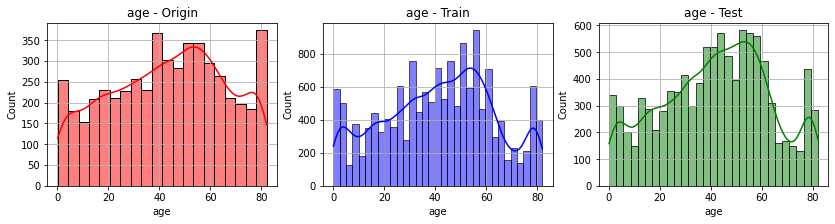

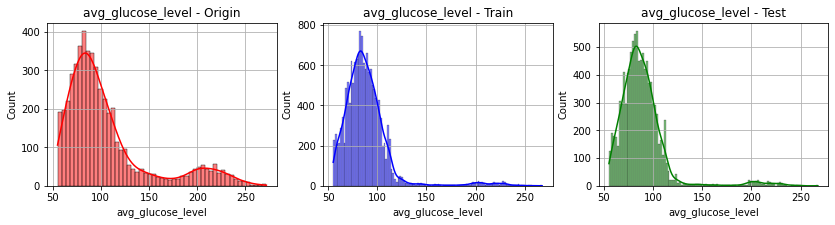

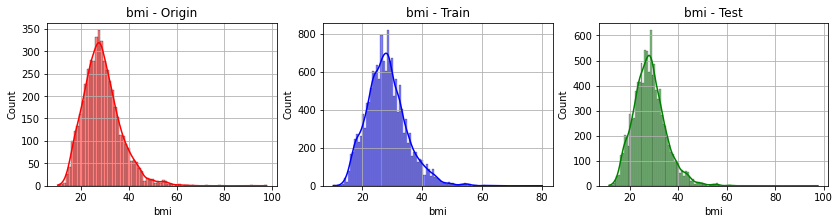

In [ ]:
for f in num_cols:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.histplot(x=origin[f], color='r', kde=True)
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.histplot(x=train[f], color='b', kde=True)
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3)
  sns.histplot(x=test[f],color='g', kde=True)
  plt.title(f + ' - Test')
  plt.grid()
  plt.show()

### Boxplot

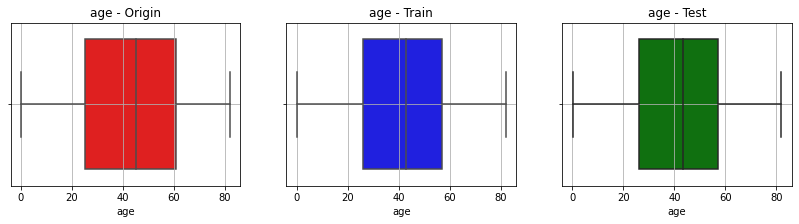

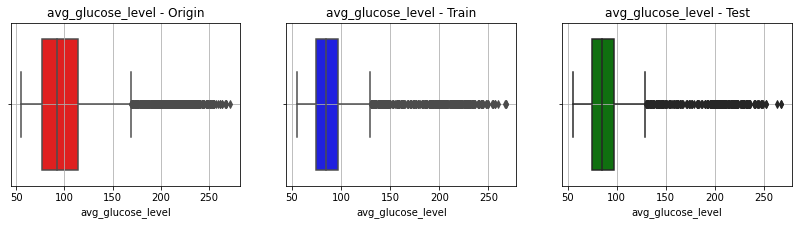

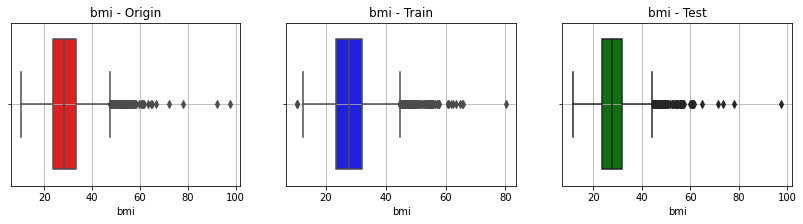

In [ ]:
for f in num_cols:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.boxplot(x=origin[f], color='r')
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.boxplot(x=train[f], color='b')
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3)
  sns.boxplot(x=test[f],color='g')
  plt.title(f + ' - Test')
  plt.grid()
  plt.show()

# 나이는 일반적으로 20세에서 60세 사이의 연령 분포에 속함
# BMI, 당 수치는 정상인 것 같지만 수치가 높음
# avg_lucose_level이 정상인 것처럼 보이기 때문에, 우리가 볼 수 있듯이 더 높은 값이 있다
# Bmi에는 40이상의 높은 수치가 있는데, 이는 40이상의 수치를 가진 사람들이 높은 비만 위험을 짊어질 수 있다는 것을 의미한다
# -> 그러므로, 이상치로 보기가 쉽지 않음

### Countplot

- 이진형
  - hypertension
  - heart_disease
  - Residence_type
  - ever_married
- 고유값 2개 초과
  - gender
  - work_type
  - smoking_status

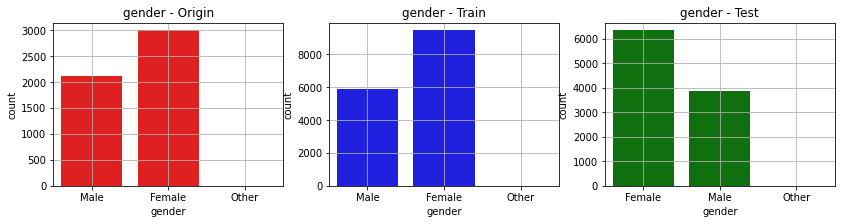

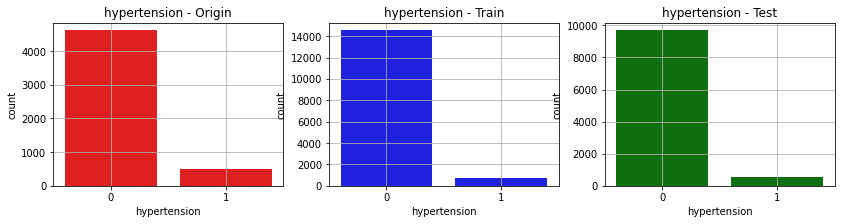

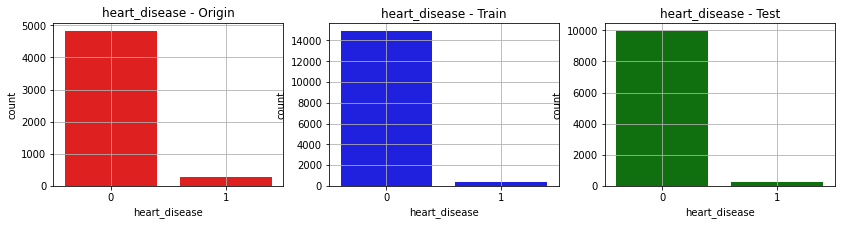

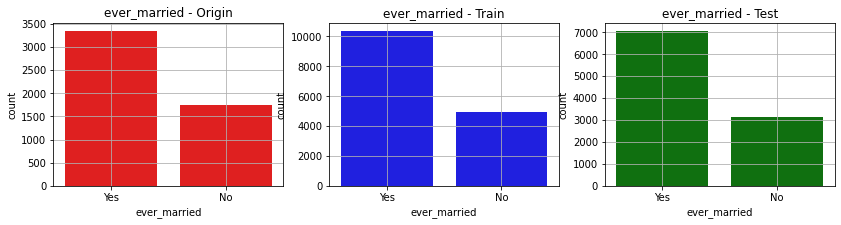

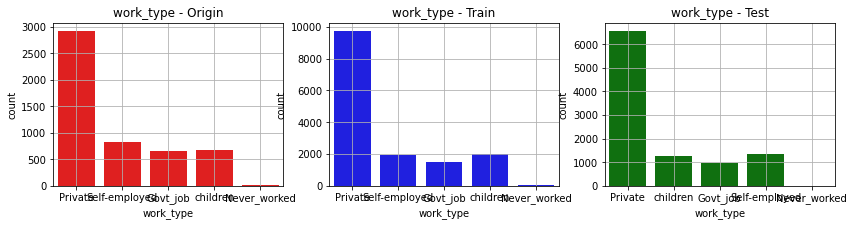

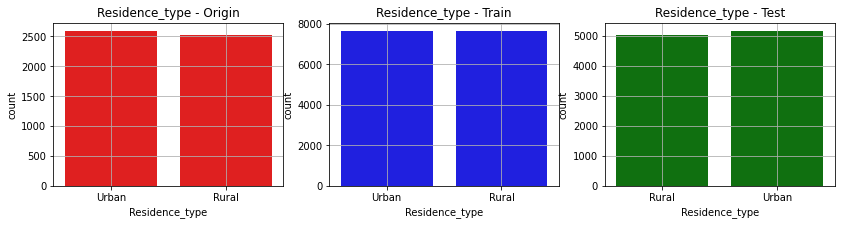

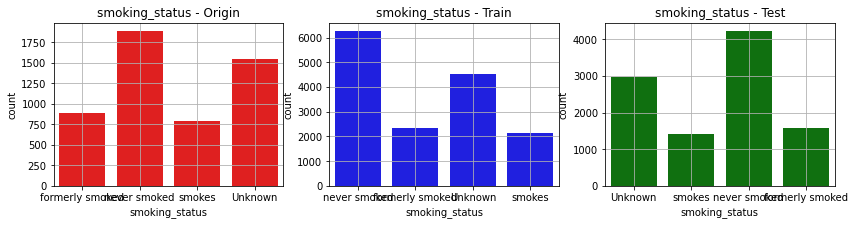

In [ ]:
for f in cat_cols:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.countplot(x= origin[f], color='r')
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.countplot(x=train[f], color='b')
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3)
  sns.countplot(x=test[f],color='g')
  plt.title(f + ' - Test')
  plt.grid()
  plt.show() 

# Gender는 여성이 좀 더 많음
# 고혈압, 심장병 여부는 뇌졸증(target)가 비율이 유사
# 거주지 타입의 비율을 거의 동일
# 작업 유형은 민간 직업이 많음

#### Gender

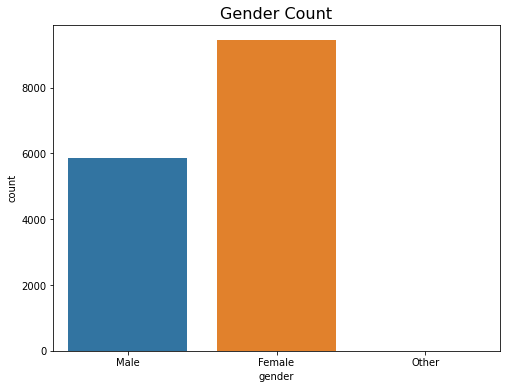

In [ ]:
# gender의 개수 시각화  -> 남성보다 여성 분포가 많이 보임
plt.figure(figsize=(8, 6))

ax = sns.countplot(x = 'gender', data = train)
ax.set_title('Gender Count', fontdict={'fontsize': 16})
plt.show()

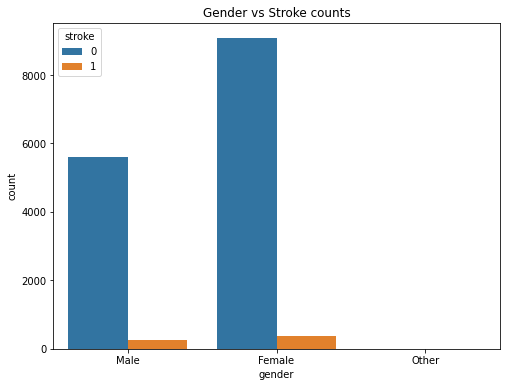

In [ ]:
# gender가 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'gender', hue='stroke', data = train )
ax.set_title('Gender vs Stroke counts')
plt.show()

In [ ]:
# gender 고유값별 개수 확인
train['gender'].value_counts()

Female    9446
Male      5857
Other        1
Name: gender, dtype: int64

In [ ]:
# 교차분석표 함수화 처리
def make_cross_tab(df, feature):
  cross_tab = pd.crosstab( df[feature], df['stroke'], normalize='index' ) *100
  cross_tab.reset_index(inplace=True)
  return cross_tab

In [ ]:
make_cross_tab(train,'gender')
# 이를 통해서 여성보다는 남성이 뇌졸증이 걸리기 쉽다
# Female 중 약 3.89%, Male 중 약 4.50%가 뇌졸중 환자로 확인됨
# other은 1명 존재하며 뇌졸중 환자가 아님 -> 이상치로 확인 

stroke,gender,0,1
0,Female,96.104171,3.895829
1,Male,95.492573,4.507427
2,Other,100.000000,0.000000


#### hypertension

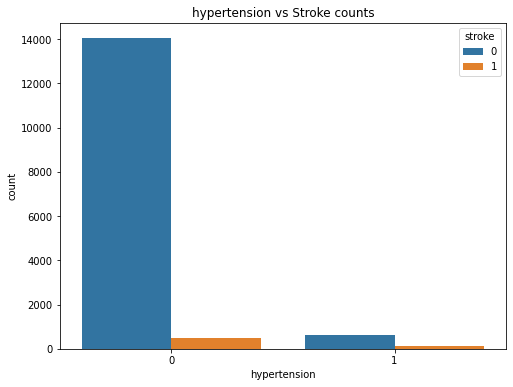

In [ ]:
# hypertension이 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'hypertension', hue='stroke', data = train )
ax.set_title('hypertension vs Stroke counts')
plt.show()

In [ ]:
make_cross_tab(train,'hypertension')
# 고혈압을 앓고 있는 사람들은 고혈압이 없는 사람들보다 뇌졸중에 걸릴 확률이 더 높다.

stroke,hypertension,0,1
0,0,96.534415,3.465585
1,1,83.180026,16.819974


#### heart_disease

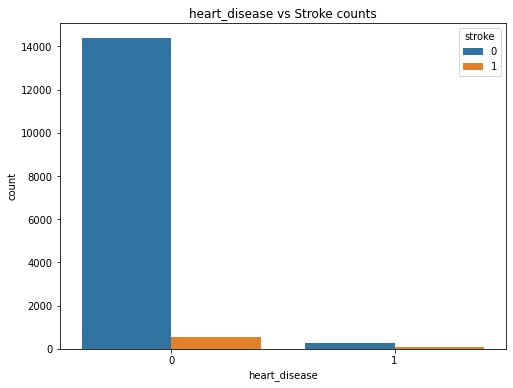

In [ ]:
# heart_disease이 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'heart_disease', hue='stroke', data = train )
ax.set_title('heart_disease vs Stroke counts')
plt.show()

In [ ]:
make_cross_tab(train,'heart_disease')
# 심장병을 앓고 있는 사람들은 심장병이 없는 사람들보다 뇌졸중에 걸릴 확률이 더 높다.

stroke,heart_disease,0,1
0,0,96.213287,3.786713
1,1,81.512605,18.487395


#### ever_married

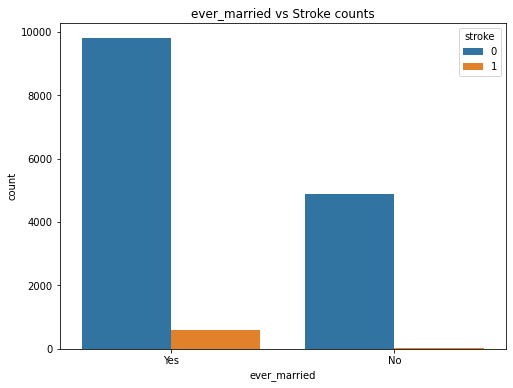

In [ ]:
# ever_married이 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'ever_married', hue='stroke', data = train )
ax.set_title('ever_married vs Stroke counts')
plt.show()

In [ ]:
make_cross_tab(train,'ever_married')
# 결혼하면 오히려 뇌졸증에 걸리기 쉬움..?

stroke,ever_married,0,1
0,No,99.166497,0.833503
1,Yes,94.309100,5.690900


#### work_type

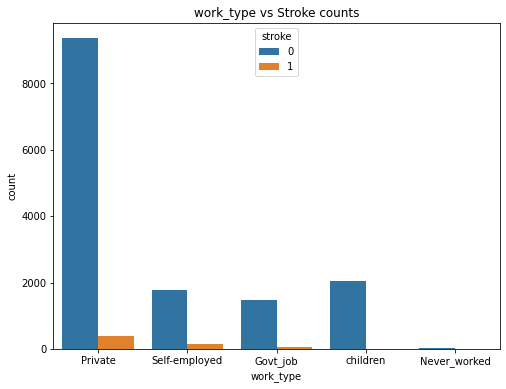

In [ ]:
# heart_disease이 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'work_type', hue='stroke', data = train )
ax.set_title('work_type vs Stroke counts')
plt.show()

In [ ]:
# work_type 고유값별 개수 확인
train['work_type'].value_counts()

Private          9752
children         2038
Self-employed    1939
Govt_job         1533
Never_worked       42
Name: work_type, dtype: int64

In [ ]:
make_cross_tab(train,'work_type')
# 일을 해본 사람들은 뇌졸중 위험 확률이 가장 높다 / 일을 아예 한 사람은 가장 낮음
# -> 다만 데이터 분포가 적은 Never_worked, children과  Govt_job	, Private을 합쳐서 새로운 피처를 만들수 있겠다	

stroke,work_type,0,1
0,Govt_job,95.499022,4.500978
1,Never_worked,100.000000,0.000000
2,Private,95.857260,4.142740
3,Self-employed,91.851470,8.148530
4,children,99.950932,0.049068


#### Residence_type

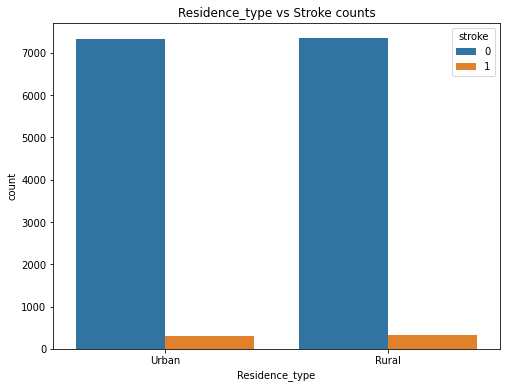

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'Residence_type', hue='stroke', data = train )
ax.set_title('Residence_type vs Stroke counts')
plt.show()

In [ ]:
make_cross_tab(train,'Residence_type')
# -> 대상 변수에 대한 값의 영향이 동일하기 때문에 이 기능인 Residence_type을 제거하는 것을 고려

stroke,Residence_type,0,1
0,Rural,95.863779,4.136221
1,Urban,95.876963,4.123037


#### smoking_status

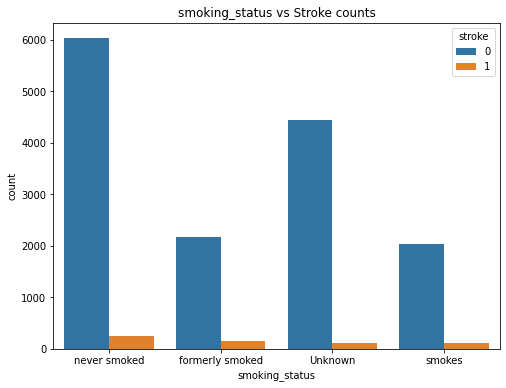

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'smoking_status', hue='stroke', data = train )
ax.set_title('smoking_status vs Stroke counts')
plt.show()

In [ ]:
make_cross_tab(train,'smoking_status')
# 알려지지 않은 값과 절대 흡연하지 않는 값은 뇌졸중에 걸릴 가능성이 낮은 반면 
# 이전에 흡연된 값과 흡연 값은 뇌졸중에 걸릴 가능성이 더 높습니다.

stroke,smoking_status,0,1
0,Unknown,97.622716,2.377284
1,formerly smoked,93.196406,6.803594
2,never smoked,95.908295,4.091705
3,smokes,94.960336,5.039664


### Stripplot

- age :  뇌졸중에 걸린 사람들은 일반적으로 40-80 사이에 분포되어 있고, 여성이 남성보다 더 많다, 젊은 사람들은 거의 X 
- bmi : 뇌졸중 환자의 bmi 수치는 약 20 ~ 40에 분포되어 있으나 뇌졸중 환자가 아닌 사람 또한 비슷한 구간에 분표되어 있어 변별력은 없을 것이라고 예상됨
- 평균 당수치 : 뇌졸중 환자 중 당 수치가 높은 사람보다 낮은 사람이 많다 => 당수치와의 상관관계는 적은 것으로 예상됨

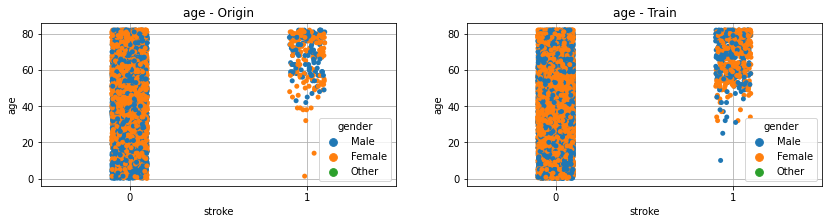

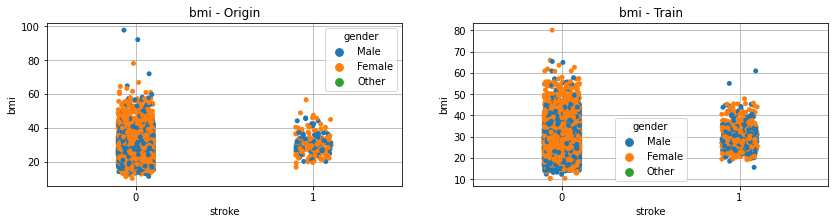

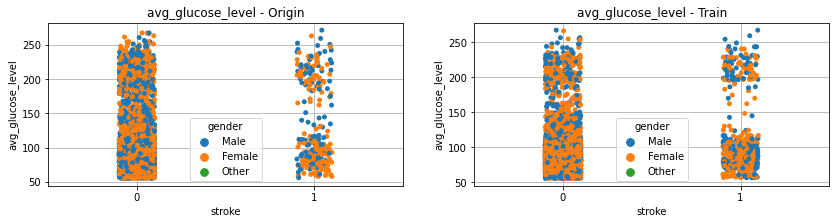

In [ ]:
# 범주형 데이터의 산점도 : stripplot : (https://steadiness-193.tistory.com/184) 

strip_feat = ['age','bmi','avg_glucose_level']

for f in strip_feat:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,2,1)
  sns.stripplot( x="stroke", y = f, hue="gender", data=origin)
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,2,2)
  sns.stripplot( x="stroke", y = f,hue="gender", data=train)
  plt.title(f + ' - Train')
  plt.grid()
  plt.show() 

### Lineplot

- 첫 번째 그래프의 경우, 20-60세 사이의 사람들은 높은 bmi 값을 가진다
- 두 번째 그래프에 따르면, 40세 이상의 사람들은 당 수치가 높다는 것을 의미하는데, 이는 이 사람들이 당뇨병 환자가 될 수 있다.
- 마지막 그래프의 경우, 당 수치가 낮으면 bmi도 같이 낮아진다(상관관계).

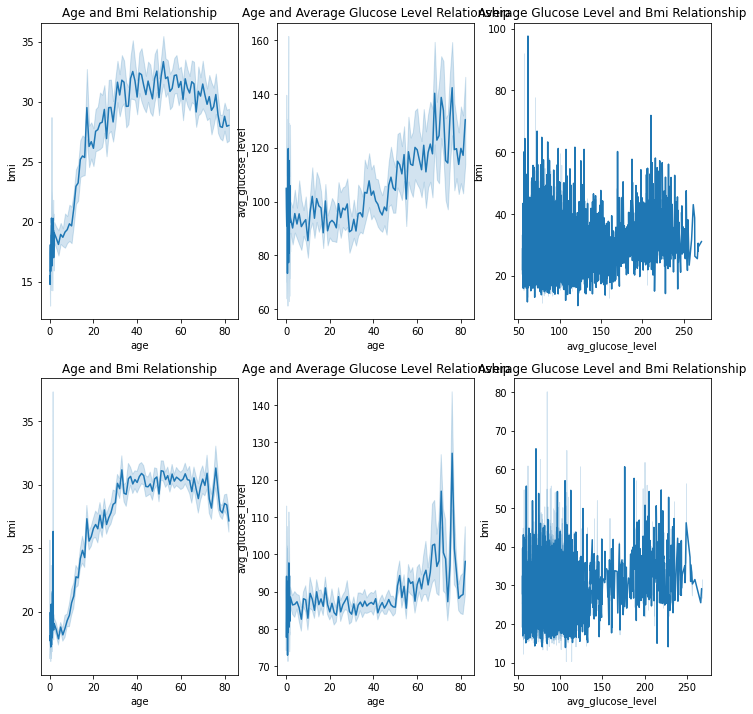

In [ ]:
fig, axes = plt.subplots(figsize=(12,12), ncols=3, nrows=2)

sns.set_style('whitegrid')

ax1 = sns.lineplot(x="age",y="bmi",data=origin, ax=axes[0][0])
ax1.set_title("Age and Bmi Relationship")

ax2 = sns.lineplot(x="age",y="avg_glucose_level",data=origin, ax=axes[0][1])
ax2.set_title("Age and Average Glucose Level Relationship")

ax3 = sns.lineplot(x="avg_glucose_level",y="bmi",data=origin, ax=axes[0][2])
ax3.set_title("Average Glucose Level and Bmi Relationship")

ax4 = sns.lineplot(x="age",y="bmi",data=train, ax=axes[1][0])
ax4.set_title("Age and Bmi Relationship")

ax5 = sns.lineplot(x="age",y="avg_glucose_level",data=train, ax=axes[1][1])
ax5.set_title("Age and Average Glucose Level Relationship")

ax6 = sns.lineplot(x="avg_glucose_level",y="bmi",data=train, ax=axes[1][2])
ax6.set_title("Average Glucose Level and Bmi Relationship")

plt.show()

## Heatmap

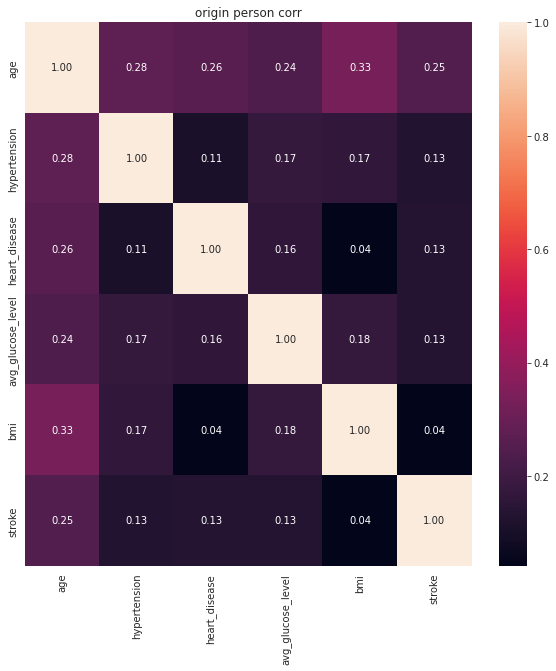

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(origin.corr(), 
            cbar=True, 
            annot=True, 
            fmt='.2f')
plt.title("origin person corr")
plt.show()

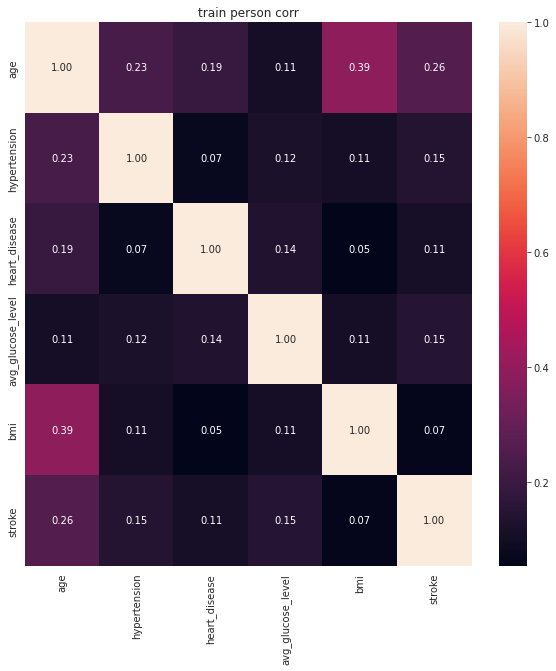

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), 
            cbar=True, 
            annot=True, 
            fmt='.2f')
plt.title("train person corr")
plt.show()

# Age, hypertension,avg_glucose_level,heart_disease, bmi대체적으로 상관관계가 있음

# 피쳐 엔지니어링

In [ ]:
# 데이터 가져오기

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_path = '/content/drive/MyDrive/모듈프젝2/B팀-분류/data/playground-series-season-3-episode-2/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv') 
origin = pd.read_csv(data_path + 'healthcare-dataset-stroke-data.csv')

origin.shape, train.shape, test.shape, submission.shape

((5110, 12), (15304, 12), (10204, 11), (10204, 2))

In [ ]:
# 뇌졸증 환자에 대해서만 가져오기
origin_stroke_1 =  origin[origin[['stroke']].all(1)]
origin_stroke_1.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
# train 데이터 셋에 추가
train = pd.concat([origin_stroke_1,train])
train.shape

(15802, 12)

## 데이터 합치기

In [ ]:
all_data = pd.concat([train,test], ignore_index=True)
all_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1.0
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1.0
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1.0
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1.0
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26001,25503,Female,27.0,0,0,No,Private,Urban,75.77,17.6,never smoked,NaN
26002,25504,Male,49.0,0,0,Yes,Private,Urban,102.91,26.7,Unknown,NaN
26003,25505,Female,3.0,0,0,No,children,Rural,104.04,18.3,Unknown,NaN
26004,25506,Male,31.0,0,0,Yes,Private,Urban,82.41,28.7,never smoked,NaN


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26006 entries, 0 to 26005
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 26006 non-null  int64  
 1   gender             26006 non-null  object 
 2   age                26006 non-null  float64
 3   hypertension       26006 non-null  int64  
 4   heart_disease      26006 non-null  int64  
 5   ever_married       26006 non-null  object 
 6   work_type          26006 non-null  object 
 7   Residence_type     26006 non-null  object 
 8   avg_glucose_level  26006 non-null  float64
 9   bmi                25926 non-null  float64
 10  smoking_status     26006 non-null  object 
 11  stroke             15802 non-null  float64
dtypes: float64(4), int64(3), object(5)
memory usage: 2.4+ MB


In [ ]:
all_data.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                     80
smoking_status           0
stroke               10204
dtype: int64

In [ ]:
all_data.nunique().sort_values()

hypertension             2
heart_disease            2
ever_married             2
Residence_type           2
stroke                   2
gender                   3
smoking_status           4
work_type                5
age                    109
bmi                    441
avg_glucose_level     4391
id                   25677
dtype: int64

In [ ]:
# 앞 선 EDA 결과를 통해서 id, Residence_type. 제거
all_data.drop(columns=['id','Residence_type'],inplace=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25757 entries, 0 to 25756
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             25757 non-null  object 
 1   age                25757 non-null  float64
 2   hypertension       25757 non-null  int64  
 3   heart_disease      25757 non-null  int64  
 4   ever_married       25757 non-null  object 
 5   work_type          25757 non-null  object 
 6   avg_glucose_level  25757 non-null  float64
 7   bmi                25717 non-null  float64
 8   smoking_status     25757 non-null  object 
 9   stroke             15553 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 2.0+ MB


## 결측치 처리

In [ ]:
# 앞 서 origin 데이터에서 bmi를 최빈값으로 처리

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")

all_data[['bmi']] = imputer.fit_transform(all_data[['bmi']])

In [ ]:
all_data.isnull().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
avg_glucose_level        0
bmi                      0
smoking_status           0
stroke               10204
dtype: int64

## 범주형 데이터 인코딩

- gender 
  - gender의 other를 female로 변환


In [ ]:
# gender의 other 위치 확인
all_data[all_data['gender'].str.contains('Other')]

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
9612,Other,9.0,0,0,No,children,96.04,18.0,Unknown,0.0
20182,Other,56.0,0,0,Yes,Private,102.53,35.0,Unknown,NaN


In [ ]:
# Other 값을 Male로 변경
all_data.loc[all_data.index.isin([9612, 20182]), 'gender'] = 'Male'

In [ ]:
# 데이터 변경 후, 교차 분석표 재확인
make_cross_tab(all_data,'gender')

stroke,gender,0.0,1.0
0,Female,94.690727,5.309273
1,Male,93.764666,6.235334


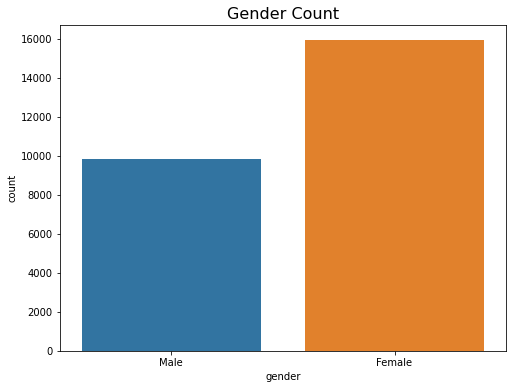

In [ ]:
# 시각화 재확인
plt.figure(figsize=(8, 6))

ax = sns.countplot(x = 'gender', data = all_data)
ax.set_title('Gender Count', fontdict={'fontsize': 16})
plt.show()

- smoking_status
  - 비흡연 vs 흡연 => 이진형 형태로 변환
  - smoking_status의 Unknown을 never_smoked로 변환
  - smoking_status의 formerly smoked를 smoked로 변환

In [ ]:
print(pd.unique(all_data["smoking_status"]))

['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [ ]:
# smoking_status에 unknown 확인
all_data[all_data['smoking_status'].str.contains('Unknown')]

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
8,Female,59.00,0,0,Yes,Private,76.15,23.4,Unknown,1.0
9,Female,78.00,0,0,Yes,Private,58.57,24.2,Unknown,1.0
13,Male,78.00,0,1,Yes,Private,219.84,23.4,Unknown,1.0
19,Male,57.00,0,1,No,Govt_job,217.08,23.4,Unknown,1.0
23,Male,82.00,0,1,Yes,Private,208.30,32.5,Unknown,1.0
...,...,...,...,...,...,...,...,...,...,...
25731,Female,1.24,0,0,No,children,92.13,13.8,Unknown,NaN
25742,Female,57.00,0,0,Yes,Private,77.93,35.7,Unknown,NaN
25753,Male,49.00,0,0,Yes,Private,102.91,26.7,Unknown,NaN
25754,Female,3.00,0,0,No,children,104.04,18.3,Unknown,NaN


In [ ]:
all_data[all_data['smoking_status'].str.contains('formerly smoked')]

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,228.69,36.6,formerly smoked,1.0
5,Male,81.0,0,0,Yes,Private,186.21,29.0,formerly smoked,1.0
24,Male,71.0,0,0,Yes,Private,102.87,27.2,formerly smoked,1.0
26,Female,65.0,0,0,Yes,Private,100.98,28.2,formerly smoked,1.0
29,Male,59.0,0,0,Yes,Private,211.78,23.4,formerly smoked,1.0
...,...,...,...,...,...,...,...,...,...,...
25740,Male,43.0,0,0,Yes,Govt_job,85.07,20.0,formerly smoked,NaN
25744,Female,34.0,0,0,Yes,Self-employed,81.98,29.0,formerly smoked,NaN
25745,Female,43.0,0,0,Yes,Govt_job,84.99,25.4,formerly smoked,NaN
25747,Female,33.0,0,0,Yes,Private,105.19,27.4,formerly smoked,NaN


In [ ]:
# Unknown -> never smoked / 'formerly smoked' -> 'smokes' 변경
all_data["smoking_status"] = all_data["smoking_status"].replace({
    'Unknown': 'never smoked',
    'formerly smoked': 'smokes'
})

In [ ]:
all_data['smoking_status'].unique() 

array(['smokes', 'never smoked'], dtype=object)

In [ ]:
# 데이터 변경 후, 교차 분석표 재확인
make_cross_tab(all_data,'smoking_status')

stroke,smoking_status,0.0,1.0
0,never smoked,95.420126,4.579874
1,smokes,91.746516,8.253484


In [ ]:
all_data['smoking_status'].value_counts()

- Work_type
  - work_type 중 children 을 Never_worked로 대체해보기 
  - private와 Govt_job 합쳐보기 

In [ ]:
all_data['work_type'] = all_data['work_type'].replace({
    'children' : 'Never_worked',
    'Private' : 'employee',
    'Govt_job' :'employee'})

In [ ]:
all_data['work_type'].unique() 

array(['employee', 'Self-employed', 'Never_worked'], dtype=object)

In [ ]:
make_cross_tab(all_data,'work_type')

stroke,work_type,0.0,1.0
0,Never_worked,99.855908,0.144092
1,Self-employed,88.872255,11.127745
2,employee,94.287957,5.712043


### One-Hot Encoding

In [ ]:
all_data.nunique().sort_values()

gender                  2
hypertension            2
heart_disease           2
ever_married            2
smoking_status          2
stroke                  2
work_type               3
age                   109
bmi                   441
avg_glucose_level    4391
dtype: int64

In [ ]:
# 고유값 3개 미만
nom_features = ['gender','hypertension','heart_disease','ever_married','smoking_status','work_type']
all_data[nom_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25757 entries, 0 to 25756
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          25757 non-null  object
 1   hypertension    25757 non-null  int64 
 2   heart_disease   25757 non-null  int64 
 3   ever_married    25757 non-null  object
 4   smoking_status  25757 non-null  object
 5   work_type       25757 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [ ]:
all_data[nom_features]
# hypertension,heart_disease	이진형이므로 원-핫 인코딩 제외

,gender,hypertension,heart_disease,ever_married,smoking_status,work_type
0,Male,0,1,Yes,smokes,employee
1,Female,0,0,Yes,never smoked,Self-employed
2,Male,0,1,Yes,never smoked,employee
3,Female,0,0,Yes,smokes,employee
4,Female,1,0,Yes,never smoked,Self-employed
...,...,...,...,...,...,...
25752,Female,0,0,No,never smoked,employee
25753,Male,0,0,Yes,never smoked,employee
25754,Female,0,0,No,never smoked,Never_worked
25755,Male,0,0,Yes,never smoked,employee


In [ ]:
from sklearn.preprocessing import OneHotEncoder

nom_features = ['gender','ever_married','smoking_status','work_type']

onehot = OneHotEncoder() # OneHotEncoder 객체 생성

# 원-핫 인코딩 적용
print( all_data[nom_features].info() )
encoded_nom_matrix = onehot.fit_transform(all_data[nom_features])

encoded_nom_matrix

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25757 entries, 0 to 25756
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          25757 non-null  object
 1   ever_married    25757 non-null  object
 2   smoking_status  25757 non-null  object
 3   work_type       25757 non-null  object
dtypes: object(4)
memory usage: 805.0+ KB
None


<25757x9 sparse matrix of type '<class 'numpy.float64'>'
	with 103028 stored elements in Compressed Sparse Row format>

In [ ]:
all_data = all_data.drop(nom_features, axis=1) # 기존 명목형 피처 삭제

In [ ]:
all_data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,67.0,0,1,228.69,36.6,1.0
1,61.0,0,0,202.21,23.4,1.0
2,80.0,0,1,105.92,32.5,1.0
3,49.0,0,0,171.23,34.4,1.0
4,79.0,1,0,174.12,24.0,1.0


## 파생 피처 생성

- 나이별 bmi 비율 어느정도 되는가?
- 나이 * BMI
- BMI Prime : [BMI Prime Calculator](https://captaincalculator.com/health/weight/bmi-prime-calculator/) 참고
- 비만도 = 평균 당 수치 * bmi / 1000

  - [5th Place Solution](https://www.kaggle.com/competitions/playground-series-s3e2/discussion/378780)

In [ ]:
# age와 avg_glucose_level이 float형태이므로 int 형태로 변환 필요 

all_data['age'] = all_data['age'].astype(int)
all_data['avg_glucose_level'] = all_data['avg_glucose_level'].astype(int)

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25757 entries, 0 to 25756
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                25757 non-null  int64  
 1   hypertension       25757 non-null  int64  
 2   heart_disease      25757 non-null  int64  
 3   avg_glucose_level  25757 non-null  int64  
 4   bmi                25757 non-null  float64
 5   stroke             15553 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 1.2 MB


In [ ]:
def generate_features(df):
    df['age/bmi'] = df.age / df.bmi
    df['age*bmi'] = df.age * df.bmi
    df['bmi/prime'] = df.bmi / 25
    df['obesity'] = df.avg_glucose_level * df.bmi / 1000
    return df

In [ ]:
generate_features(all_data)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age/bmi,age*bmi,bmi/prime,obesity
0,67,0,1,228,36.6,1.0,1.830601,2452.2,1.464,8.3448
1,61,0,0,202,23.4,1.0,2.606838,1427.4,0.936,4.7268
2,80,0,1,105,32.5,1.0,2.461538,2600.0,1.300,3.4125
3,49,0,0,171,34.4,1.0,1.424419,1685.6,1.376,5.8824
4,79,1,0,174,24.0,1.0,3.291667,1896.0,0.960,4.1760
...,...,...,...,...,...,...,...,...,...,...
25752,27,0,0,75,17.6,NaN,1.534091,475.2,0.704,1.3200
25753,49,0,0,102,26.7,NaN,1.835206,1308.3,1.068,2.7234
25754,3,0,0,104,18.3,NaN,0.163934,54.9,0.732,1.9032
25755,31,0,0,82,28.7,NaN,1.080139,889.7,1.148,2.3534


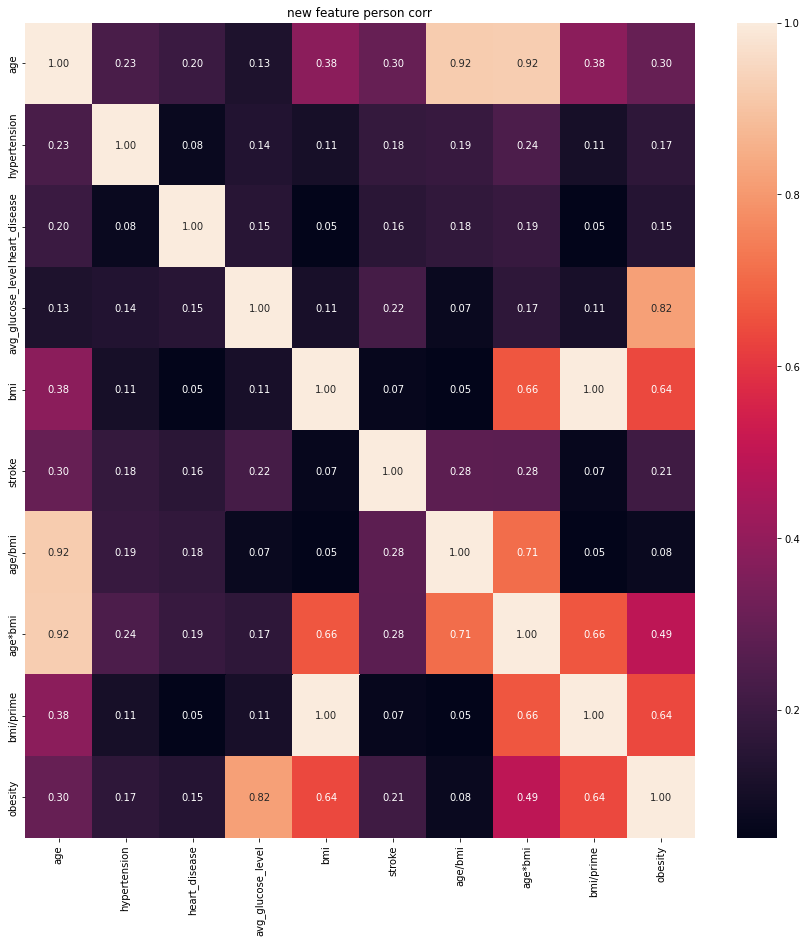

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(all_data.corr(), 
            cbar=True, 
            annot=True, 
            fmt='.2f')
plt.title("new feature person corr")
plt.show()
# stroke 예측 시 어느정도 상관관계가 생긴다

## 피처 스케일링

In [ ]:
from sklearn.preprocessing import MinMaxScaler

num_features = ['age', 'avg_glucose_level', 'bmi', 'age/bmi', 'age*bmi', 'bmi/prime', 'obesity']

minmax = MinMaxScaler()

all_data[num_features] = minmax.fit_transform(all_data[num_features])

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25757 entries, 0 to 25756
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                25757 non-null  float64
 1   hypertension       25757 non-null  int64  
 2   heart_disease      25757 non-null  int64  
 3   avg_glucose_level  25757 non-null  float64
 4   bmi                25757 non-null  float64
 5   stroke             15553 non-null  float64
 6   age/bmi            25757 non-null  float64
 7   age*bmi            25757 non-null  float64
 8   bmi/prime          25757 non-null  float64
 9   obesity            25757 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 2.0 MB


# 스케일링된 데이터 병합

In [ ]:
# 병합 전, 타겟변수 제거
all_data.drop(columns=['stroke'],inplace=True)

KeyError: ignored

In [ ]:
all_data

,age,hypertension,heart_disease,avg_glucose_level,bmi,age/bmi,age*bmi,bmi/prime,obesity
0,0.817073,0,1,0.800926,0.301260,0.263149,0.502500,0.301260,0.426069
1,0.743902,0,0,0.680556,0.150057,0.374733,0.292500,0.150057,0.226300
2,0.975610,0,1,0.231481,0.254296,0.353846,0.532787,0.254296,0.153731
3,0.597561,0,0,0.537037,0.276060,0.204760,0.345410,0.276060,0.290107
4,0.963415,1,0,0.550926,0.156930,0.473177,0.388525,0.156930,0.195888
...,...,...,...,...,...,...,...,...,...
25752,0.329268,0,0,0.092593,0.083620,0.220526,0.097377,0.083620,0.038192
25753,0.597561,0,0,0.217593,0.187858,0.263811,0.268094,0.187858,0.115682
25754,0.036585,0,0,0.226852,0.091638,0.023566,0.011250,0.091638,0.070394
25755,0.378049,0,0,0.125000,0.210767,0.155270,0.182316,0.210767,0.095252


In [ ]:
encoded_nom_matrix

<25757x9 sparse matrix of type '<class 'numpy.float64'>'
	with 103028 stored elements in Compressed Sparse Row format>

In [ ]:
from scipy import sparse



# 인코딩 및 스케일링된 피처 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data),
                               encoded_nom_matrix],
                              format='csr')
all_data_sprs

<25757x18 sparse matrix of type '<class 'numpy.float64'>'
	with 284708 stored elements in Compressed Sparse Row format>

# 데이터 나누기

In [ ]:
num_train = len(train) # 훈련 데이터 개수 

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train] # 0 ~ num_train - 1행
X_sub = all_data_sprs[num_train:] # num_train ~ 마지막 행
y = train['stroke'] 

X.shape, X_sub.shape, y.shape

((15553, 18), (10204, 18), (15553,))

In [ ]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11664, 18) (3889, 18) (11664,) (3889,)


# 베이스라인 구축

In [ ]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 이진 분류, 선형 모델을 내부적으로 가지고, 피처가 많아도 학습 속도가 빠른 로지스틱 회귀 사용
clf = LogisticRegression()

# 하이퍼파라미터 값 목록
clf_params = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], # 규제 강도, 높을 수록 강함
             'max_iter':[10, 50, 100, 200, 400, 600, 800, 1000], #  모델 성능을 오리기 위해서 학습의 반복 횟수 제한
             'solver':['liblinear'], # 과적합 방지 지표 :  L1,L2를 모두 지원
             'random_state':[0]}

# 그리드서치 객체 생성
gridsearch_logistic_model = GridSearchCV(clf,clf_params,scoring='roc_auc',cv=10)
# 그리드서치 수행
gridsearch_logistic_model.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarni

CPU times: user 14.4 s, sys: 37.4 ms, total: 14.5 s
Wall time: 14.6 s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [10, 50, 100, 200, 400, 600, 800, 1000],
                         'random_state': [0], 'solver': ['liblinear']},
             scoring='roc_auc')

In [ ]:
print('최적 하이퍼파라미터:', gridsearch_logistic_model.best_params_)
print('위 하이퍼파리머터 사용시 roc_auc ', gridsearch_logistic_model.best_score_)

최적 하이퍼파라미터: {'C': 100, 'max_iter': 10, 'random_state': 0, 'solver': 'liblinear'}
위 하이퍼파리머터 사용시 roc_auc  0.8866512782728403


In [ ]:
y_preds = gridsearch_logistic_model.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수

# 검증 데이터 ROC AUC
roc_auc = roc_auc_score(y_test, y_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

검증 데이터 ROC AUC : 0.8917


In [ ]:
# 풀 데이터 활용 
gridsearch_logistic_model.fit(X, y)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarni

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [10, 50, 100, 200, 400, 600, 800, 1000],
                         'random_state': [0], 'solver': ['liblinear']},
             scoring='roc_auc')

In [ ]:
print('최적 하이퍼파라미터:', gridsearch_logistic_model.best_params_)
print('위 하이퍼파리머터 사용시 roc_auc ', gridsearch_logistic_model.best_score_)

최적 하이퍼파라미터: {'C': 1000, 'max_iter': 10, 'random_state': 0, 'solver': 'liblinear'}
위 하이퍼파리머터 사용시 roc_auc  0.8877814872623407


In [ ]:
y_preds = gridsearch_logistic_model.best_estimator_.predict_proba(X_sub)[:,1]
y_preds

array([0.04504715, 0.19186741, 0.00093303, ..., 0.0007052 , 0.00440569,
       0.00038669])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

preds = minmax.fit_transform(y_preds.reshape(-1, 1))

In [ ]:
submission = pd.DataFrame({
    'id': np.arange(15304, 25508),
    'stroke': preds.reshape(-1, )
})
submission.head()

,id,stroke
0,15304,0.056516
1,15305,0.241476
2,15306,0.000943
3,15307,0.061229
4,15308,0.010341


In [ ]:
submission.to_csv('submission_basic.csv', index=False )
# Private Score: 0.88878 / Public score: 0.86597

# 모델 선정 및 비교

- sparse matrix -> 배열 형태로 변환 > train,test
- y는 train에서 가져온값

In [ ]:
X_train_df = pd.DataFrame(X.toarray()).reset_index(drop=True)
X_test_df = pd.DataFrame(X_sub.toarray()).reset_index(drop=True)
y_train_df = pd.DataFrame(y, columns=['stroke']).reset_index(drop=True)

In [ ]:
X_train_df.shape, X_test_df.shape, y_train_df.shape

((15553, 18), (10204, 18), (15553, 1))

In [ ]:
data = pd.concat([X_train_df, y_train_df], axis=1)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,stroke
0,0.817073,0.0,1.0,0.800926,0.301260,0.263149,0.502500,0.301260,0.426069,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1
1,0.743902,0.0,0.0,0.680556,0.150057,0.374733,0.292500,0.150057,0.226300,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1
2,0.975610,0.0,1.0,0.231481,0.254296,0.353846,0.532787,0.254296,0.153731,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1
3,0.597561,0.0,0.0,0.537037,0.276060,0.204760,0.345410,0.276060,0.290107,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1
4,0.963415,1.0,0.0,0.550926,0.156930,0.473177,0.388525,0.156930,0.195888,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15548,0.268293,0.0,0.0,0.078704,0.105384,0.162179,0.087910,0.105384,0.042831,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
15549,0.560976,1.0,0.0,0.212963,0.249714,0.205997,0.302582,0.249714,0.144322,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0
15550,0.914634,0.0,0.0,0.148148,0.182131,0.411498,0.402664,0.182131,0.091166,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0
15551,0.560976,0.0,0.0,0.212963,0.139748,0.293889,0.212090,0.139748,0.090785,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0


In [ ]:
from sklearn.model_selection import train_test_split

y = data['stroke']
X = data.drop(columns=['stroke'])

# 훈련 데이터, 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=42,stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11664, 18) (3889, 18) (11664,) (3889,)


In [ ]:
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score

def roc_auc_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    roc_auc_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(X_train), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train1, X_test1 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train1, y_test1 = y_train.iloc[train_index], y_train.iloc[test_index]
        clf = model.fit(X_train1, y_train1)
        pred = clf.predict_proba(X_test1)[:, 1]
        roc_auc = roc_auc_score(y_test1, pred)
        roc_auc_list.append(roc_auc)
    return model_name, roc_auc_list

def print_roc_auc_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = roc_auc_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} ROC AUC: {r:.4f}')
    print(f'\n{model_name} mean ROC AUC: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.2 MB/s eta 0:00:00


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()
cat = CatBoostClassifier()

In [ ]:
models = []
scores = []
for model in [lr, dt, rf, gb, ada, xgb, lgbm, cat]:
    model_name, mean_score = print_roc_auc_score(model)
    models.append(model_name)
    scores.append(mean_score)

LogisticRegression Cross Validations...:  80%|████████  | 8/10 [00:00<00:00, 20.48it/s]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

LogisticRegression Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 17.52it/s]


1 FOLDS: LogisticRegression ROC AUC: 0.8759
2 FOLDS: LogisticRegression ROC AUC: 0.9115
3 FOLDS: LogisticRegression ROC AUC: 0.8534
4 FOLDS: LogisticRegression ROC AUC: 0.9060
5 FOLDS: LogisticRegression ROC AUC: 0.9082
6 FOLDS: LogisticRegression ROC AUC: 0.8378
7 FOLDS: LogisticRegression ROC AUC: 0.8711
8 FOLDS: LogisticRegression ROC AUC: 0.8929
9 FOLDS: LogisticRegression ROC AUC: 0.8748
10 FOLDS: LogisticRegression ROC AUC: 0.8930

LogisticRegression mean ROC AUC: 0.8825


DecisionTreeClassifier Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 20.80it/s]


1 FOLDS: DecisionTreeClassifier ROC AUC: 0.5718
2 FOLDS: DecisionTreeClassifier ROC AUC: 0.6271
3 FOLDS: DecisionTreeClassifier ROC AUC: 0.5912
4 FOLDS: DecisionTreeClassifier ROC AUC: 0.6668
5 FOLDS: DecisionTreeClassifier ROC AUC: 0.6223
6 FOLDS: DecisionTreeClassifier ROC AUC: 0.5876
7 FOLDS: DecisionTreeClassifier ROC AUC: 0.5884
8 FOLDS: DecisionTreeClassifier ROC AUC: 0.6330
9 FOLDS: DecisionTreeClassifier ROC AUC: 0.5942
10 FOLDS: DecisionTreeClassifier ROC AUC: 0.5962

DecisionTreeClassifier mean ROC AUC: 0.6079


RandomForestClassifier Cross Validations...: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


1 FOLDS: RandomForestClassifier ROC AUC: 0.8214
2 FOLDS: RandomForestClassifier ROC AUC: 0.8808
3 FOLDS: RandomForestClassifier ROC AUC: 0.8216
4 FOLDS: RandomForestClassifier ROC AUC: 0.8751
5 FOLDS: RandomForestClassifier ROC AUC: 0.8797
6 FOLDS: RandomForestClassifier ROC AUC: 0.8441
7 FOLDS: RandomForestClassifier ROC AUC: 0.8484
8 FOLDS: RandomForestClassifier ROC AUC: 0.8880
9 FOLDS: RandomForestClassifier ROC AUC: 0.8717
10 FOLDS: RandomForestClassifier ROC AUC: 0.8678

RandomForestClassifier mean ROC AUC: 0.8599


GradientBoostingClassifier Cross Validations...: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


1 FOLDS: GradientBoostingClassifier ROC AUC: 0.8065
2 FOLDS: GradientBoostingClassifier ROC AUC: 0.8990
3 FOLDS: GradientBoostingClassifier ROC AUC: 0.8470
4 FOLDS: GradientBoostingClassifier ROC AUC: 0.8995
5 FOLDS: GradientBoostingClassifier ROC AUC: 0.9077
6 FOLDS: GradientBoostingClassifier ROC AUC: 0.8463
7 FOLDS: GradientBoostingClassifier ROC AUC: 0.8669
8 FOLDS: GradientBoostingClassifier ROC AUC: 0.9075
9 FOLDS: GradientBoostingClassifier ROC AUC: 0.8671
10 FOLDS: GradientBoostingClassifier ROC AUC: 0.8959

GradientBoostingClassifier mean ROC AUC: 0.8743


AdaBoostClassifier Cross Validations...: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


1 FOLDS: AdaBoostClassifier ROC AUC: 0.8336
2 FOLDS: AdaBoostClassifier ROC AUC: 0.9026
3 FOLDS: AdaBoostClassifier ROC AUC: 0.8534
4 FOLDS: AdaBoostClassifier ROC AUC: 0.8711
5 FOLDS: AdaBoostClassifier ROC AUC: 0.8892
6 FOLDS: AdaBoostClassifier ROC AUC: 0.8492
7 FOLDS: AdaBoostClassifier ROC AUC: 0.8669
8 FOLDS: AdaBoostClassifier ROC AUC: 0.9063
9 FOLDS: AdaBoostClassifier ROC AUC: 0.8565
10 FOLDS: AdaBoostClassifier ROC AUC: 0.8907

AdaBoostClassifier mean ROC AUC: 0.8719


XGBClassifier Cross Validations...: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


1 FOLDS: XGBClassifier ROC AUC: 0.7829
2 FOLDS: XGBClassifier ROC AUC: 0.8994
3 FOLDS: XGBClassifier ROC AUC: 0.8532
4 FOLDS: XGBClassifier ROC AUC: 0.9065
5 FOLDS: XGBClassifier ROC AUC: 0.9096
6 FOLDS: XGBClassifier ROC AUC: 0.8562
7 FOLDS: XGBClassifier ROC AUC: 0.8755
8 FOLDS: XGBClassifier ROC AUC: 0.9091
9 FOLDS: XGBClassifier ROC AUC: 0.8667
10 FOLDS: XGBClassifier ROC AUC: 0.8916

XGBClassifier mean ROC AUC: 0.8751


LGBMClassifier Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


1 FOLDS: LGBMClassifier ROC AUC: 0.8078
2 FOLDS: LGBMClassifier ROC AUC: 0.8752
3 FOLDS: LGBMClassifier ROC AUC: 0.8311
4 FOLDS: LGBMClassifier ROC AUC: 0.8760
5 FOLDS: LGBMClassifier ROC AUC: 0.8964
6 FOLDS: LGBMClassifier ROC AUC: 0.8581
7 FOLDS: LGBMClassifier ROC AUC: 0.8657
8 FOLDS: LGBMClassifier ROC AUC: 0.9000
9 FOLDS: LGBMClassifier ROC AUC: 0.8612
10 FOLDS: LGBMClassifier ROC AUC: 0.8787

LGBMClassifier mean ROC AUC: 0.8650


CatBoostClassifier Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.010579
0:	learn: 0.6729454	total: 2.54ms	remaining: 2.54s
1:	learn: 0.6559353	total: 4.74ms	remaining: 2.36s
2:	learn: 0.6399377	total: 6.9ms	remaining: 2.29s
3:	learn: 0.6255470	total: 8.11ms	remaining: 2.02s
4:	learn: 0.6074952	total: 10.1ms	remaining: 2.02s
5:	learn: 0.5923631	total: 12.2ms	remaining: 2.02s
6:	learn: 0.5796494	total: 14.2ms	remaining: 2.01s
7:	learn: 0.5647785	total: 16.1ms	remaining: 2s
8:	learn: 0.5509439	total: 18.1ms	remaining: 1.99s
9:	learn: 0.5371316	total: 20.1ms	remaining: 1.99s
10:	learn: 0.5232105	total: 22ms	remaining: 1.98s
11:	learn: 0.5104584	total: 24ms	remaining: 1.98s
12:	learn: 0.4997025	total: 26ms	remaining: 1.98s
13:	learn: 0.4899610	total: 28ms	remaining: 1.98s
14:	learn: 0.4789577	total: 30ms	remaining: 1.97s
15:	learn: 0.4676213	total: 31.9ms	remaining: 1.96s
16:	learn: 0.4597825	total: 33.9ms	remaining: 1.96s
17:	learn: 0.4490238	total: 35.8ms	remaining: 1.95s
18:	learn: 0.4379407	total: 37.8ms	remaining: 1.95s
19:	le

CatBoostClassifier Cross Validations...:  10%|█         | 1/10 [00:03<00:30,  3.35s/it]

Learning rate set to 0.014211
0:	learn: 0.6679681	total: 2.75ms	remaining: 2.75s
1:	learn: 0.6448465	total: 5.59ms	remaining: 2.79s
2:	learn: 0.6233375	total: 12ms	remaining: 3.99s
3:	learn: 0.6012708	total: 14.6ms	remaining: 3.63s
4:	learn: 0.5789054	total: 16.8ms	remaining: 3.35s
5:	learn: 0.5591976	total: 19ms	remaining: 3.15s
6:	learn: 0.5400934	total: 21.2ms	remaining: 3.01s
7:	learn: 0.5226199	total: 23.4ms	remaining: 2.9s
8:	learn: 0.5053409	total: 25.6ms	remaining: 2.82s
9:	learn: 0.4891587	total: 27.8ms	remaining: 2.75s
10:	learn: 0.4764098	total: 30ms	remaining: 2.69s
11:	learn: 0.4633492	total: 32.2ms	remaining: 2.65s
12:	learn: 0.4500634	total: 34.4ms	remaining: 2.61s
13:	learn: 0.4387275	total: 36.6ms	remaining: 2.58s
14:	learn: 0.4267443	total: 38.8ms	remaining: 2.55s
15:	learn: 0.4171115	total: 41ms	remaining: 2.52s
16:	learn: 0.4052849	total: 43.2ms	remaining: 2.5s
17:	learn: 0.3952748	total: 45.4ms	remaining: 2.47s
18:	learn: 0.3840127	total: 47.5ms	remaining: 2.45s
19

CatBoostClassifier Cross Validations...:  20%|██        | 2/10 [00:06<00:26,  3.30s/it]

972:	learn: 0.0606032	total: 2.74s	remaining: 76.2ms
973:	learn: 0.0605823	total: 2.75s	remaining: 73.3ms
974:	learn: 0.0605540	total: 2.75s	remaining: 70.5ms
975:	learn: 0.0604994	total: 2.75s	remaining: 67.7ms
976:	learn: 0.0604124	total: 2.75s	remaining: 64.8ms
977:	learn: 0.0603520	total: 2.76s	remaining: 62ms
978:	learn: 0.0602909	total: 2.76s	remaining: 59.2ms
979:	learn: 0.0602386	total: 2.76s	remaining: 56.3ms
980:	learn: 0.0601704	total: 2.76s	remaining: 53.5ms
981:	learn: 0.0601498	total: 2.77s	remaining: 50.7ms
982:	learn: 0.0601132	total: 2.77s	remaining: 47.9ms
983:	learn: 0.0599998	total: 2.77s	remaining: 45ms
984:	learn: 0.0599616	total: 2.77s	remaining: 42.2ms
985:	learn: 0.0598962	total: 2.77s	remaining: 39.4ms
986:	learn: 0.0598090	total: 2.78s	remaining: 36.6ms
987:	learn: 0.0597642	total: 2.78s	remaining: 33.8ms
988:	learn: 0.0597044	total: 2.78s	remaining: 30.9ms
989:	learn: 0.0596334	total: 2.78s	remaining: 28.1ms
990:	learn: 0.0596065	total: 2.79s	remaining: 25.3

CatBoostClassifier Cross Validations...:  30%|███       | 3/10 [00:13<00:35,  5.14s/it]

Learning rate set to 0.019098
0:	learn: 0.6586980	total: 3ms	remaining: 3s
1:	learn: 0.6281221	total: 6ms	remaining: 3s
2:	learn: 0.5996351	total: 9.62ms	remaining: 3.2s
3:	learn: 0.5760017	total: 11.9ms	remaining: 2.97s
4:	learn: 0.5500571	total: 16.9ms	remaining: 3.36s
5:	learn: 0.5238828	total: 24.9ms	remaining: 4.13s
6:	learn: 0.5056878	total: 32.3ms	remaining: 4.59s
7:	learn: 0.4847010	total: 38.9ms	remaining: 4.83s
8:	learn: 0.4632506	total: 46.8ms	remaining: 5.15s
9:	learn: 0.4436807	total: 55.7ms	remaining: 5.51s
10:	learn: 0.4259439	total: 66.7ms	remaining: 6s
11:	learn: 0.4097362	total: 76.7ms	remaining: 6.32s
12:	learn: 0.3957150	total: 84.1ms	remaining: 6.39s
13:	learn: 0.3847336	total: 99.6ms	remaining: 7.01s
14:	learn: 0.3712957	total: 110ms	remaining: 7.22s
15:	learn: 0.3591542	total: 115ms	remaining: 7.05s
16:	learn: 0.3496625	total: 161ms	remaining: 9.31s
17:	learn: 0.3376066	total: 164ms	remaining: 8.97s
18:	learn: 0.3259708	total: 171ms	remaining: 8.85s
19:	learn: 0.

CatBoostClassifier Cross Validations...:  40%|████      | 4/10 [00:19<00:32,  5.43s/it]

973:	learn: 0.0764320	total: 5.07s	remaining: 135ms
974:	learn: 0.0763881	total: 5.07s	remaining: 130ms
975:	learn: 0.0763483	total: 5.08s	remaining: 125ms
976:	learn: 0.0763075	total: 5.08s	remaining: 120ms
977:	learn: 0.0762981	total: 5.08s	remaining: 114ms
978:	learn: 0.0762894	total: 5.08s	remaining: 109ms
979:	learn: 0.0762238	total: 5.09s	remaining: 104ms
980:	learn: 0.0762147	total: 5.09s	remaining: 98.6ms
981:	learn: 0.0761900	total: 5.09s	remaining: 93.4ms
982:	learn: 0.0761198	total: 5.1s	remaining: 88.1ms
983:	learn: 0.0760572	total: 5.1s	remaining: 82.9ms
984:	learn: 0.0760300	total: 5.1s	remaining: 77.7ms
985:	learn: 0.0759843	total: 5.1s	remaining: 72.5ms
986:	learn: 0.0759480	total: 5.11s	remaining: 67.3ms
987:	learn: 0.0759304	total: 5.11s	remaining: 62.1ms
988:	learn: 0.0758760	total: 5.11s	remaining: 56.9ms
989:	learn: 0.0758380	total: 5.12s	remaining: 51.7ms
990:	learn: 0.0758116	total: 5.12s	remaining: 46.5ms
991:	learn: 0.0757723	total: 5.12s	remaining: 41.3ms
992:

CatBoostClassifier Cross Validations...:  50%|█████     | 5/10 [00:26<00:28,  5.77s/it]

986:	learn: 0.0844402	total: 5.67s	remaining: 74.7ms
987:	learn: 0.0843555	total: 5.68s	remaining: 69ms
988:	learn: 0.0842755	total: 5.69s	remaining: 63.3ms
989:	learn: 0.0842630	total: 5.7s	remaining: 57.5ms
990:	learn: 0.0841833	total: 5.71s	remaining: 51.8ms
991:	learn: 0.0841319	total: 5.71s	remaining: 46.1ms
992:	learn: 0.0840833	total: 5.73s	remaining: 40.4ms
993:	learn: 0.0840699	total: 5.73s	remaining: 34.6ms
994:	learn: 0.0840405	total: 5.75s	remaining: 28.9ms
995:	learn: 0.0840205	total: 5.75s	remaining: 23.1ms
996:	learn: 0.0839639	total: 5.76s	remaining: 17.3ms
997:	learn: 0.0839360	total: 5.77s	remaining: 11.6ms
998:	learn: 0.0839290	total: 5.78s	remaining: 5.78ms
999:	learn: 0.0839129	total: 5.78s	remaining: 0us
Learning rate set to 0.022705
0:	learn: 0.6519331	total: 3.44ms	remaining: 3.44s
1:	learn: 0.6155015	total: 8.1ms	remaining: 4.04s
2:	learn: 0.5807843	total: 14.1ms	remaining: 4.69s
3:	learn: 0.5531432	total: 17.4ms	remaining: 4.33s
4:	learn: 0.5225410	total: 22.8

CatBoostClassifier Cross Validations...:  60%|██████    | 6/10 [00:30<00:20,  5.15s/it]

974:	learn: 0.0818054	total: 3.52s	remaining: 90.4ms
975:	learn: 0.0817557	total: 3.53s	remaining: 86.8ms
976:	learn: 0.0816687	total: 3.53s	remaining: 83.2ms
977:	learn: 0.0816291	total: 3.54s	remaining: 79.6ms
978:	learn: 0.0815652	total: 3.55s	remaining: 76.1ms
979:	learn: 0.0815259	total: 3.55s	remaining: 72.4ms
980:	learn: 0.0814977	total: 3.55s	remaining: 68.8ms
981:	learn: 0.0814557	total: 3.56s	remaining: 65.2ms
982:	learn: 0.0814363	total: 3.56s	remaining: 61.6ms
983:	learn: 0.0813862	total: 3.56s	remaining: 57.9ms
984:	learn: 0.0813502	total: 3.56s	remaining: 54.3ms
985:	learn: 0.0813110	total: 3.57s	remaining: 50.7ms
986:	learn: 0.0813053	total: 3.57s	remaining: 47ms
987:	learn: 0.0812780	total: 3.58s	remaining: 43.4ms
988:	learn: 0.0812166	total: 3.58s	remaining: 39.8ms
989:	learn: 0.0811824	total: 3.58s	remaining: 36.2ms
990:	learn: 0.0811538	total: 3.58s	remaining: 32.6ms
991:	learn: 0.0811104	total: 3.59s	remaining: 28.9ms
992:	learn: 0.0810711	total: 3.59s	remaining: 25

CatBoostClassifier Cross Validations...:  70%|███████   | 7/10 [00:34<00:14,  4.81s/it]

983:	learn: 0.0802483	total: 3.73s	remaining: 60.6ms
984:	learn: 0.0801780	total: 3.73s	remaining: 56.8ms
985:	learn: 0.0801389	total: 3.73s	remaining: 53ms
986:	learn: 0.0801093	total: 3.74s	remaining: 49.2ms
987:	learn: 0.0800828	total: 3.74s	remaining: 45.4ms
988:	learn: 0.0800532	total: 3.74s	remaining: 41.6ms
989:	learn: 0.0800277	total: 3.75s	remaining: 37.8ms
990:	learn: 0.0800022	total: 3.75s	remaining: 34.1ms
991:	learn: 0.0799835	total: 3.75s	remaining: 30.3ms
992:	learn: 0.0799525	total: 3.76s	remaining: 26.5ms
993:	learn: 0.0798981	total: 3.76s	remaining: 22.7ms
994:	learn: 0.0798503	total: 3.76s	remaining: 18.9ms
995:	learn: 0.0798206	total: 3.77s	remaining: 15.1ms
996:	learn: 0.0797837	total: 3.77s	remaining: 11.3ms
997:	learn: 0.0797235	total: 3.77s	remaining: 7.56ms
998:	learn: 0.0796605	total: 3.78s	remaining: 3.78ms
999:	learn: 0.0796086	total: 3.78s	remaining: 0us
Learning rate set to 0.025671
0:	learn: 0.6464383	total: 3.59ms	remaining: 3.59s
1:	learn: 0.6055818	tot

CatBoostClassifier Cross Validations...:  80%|████████  | 8/10 [00:40<00:10,  5.24s/it]

971:	learn: 0.0883448	total: 5.57s	remaining: 160ms
972:	learn: 0.0883003	total: 5.58s	remaining: 155ms
973:	learn: 0.0882762	total: 5.59s	remaining: 149ms
974:	learn: 0.0882025	total: 5.59s	remaining: 143ms
975:	learn: 0.0881711	total: 5.6s	remaining: 138ms
976:	learn: 0.0881359	total: 5.6s	remaining: 132ms
977:	learn: 0.0880856	total: 5.6s	remaining: 126ms
978:	learn: 0.0880553	total: 5.61s	remaining: 120ms
979:	learn: 0.0879876	total: 5.61s	remaining: 115ms
980:	learn: 0.0879314	total: 5.62s	remaining: 109ms
981:	learn: 0.0878951	total: 5.62s	remaining: 103ms
982:	learn: 0.0878533	total: 5.62s	remaining: 97.3ms
983:	learn: 0.0878375	total: 5.63s	remaining: 91.5ms
984:	learn: 0.0878169	total: 5.63s	remaining: 85.8ms
985:	learn: 0.0877987	total: 5.63s	remaining: 80ms
986:	learn: 0.0877697	total: 5.64s	remaining: 74.3ms
987:	learn: 0.0877382	total: 5.64s	remaining: 68.5ms
988:	learn: 0.0877168	total: 5.65s	remaining: 62.8ms
989:	learn: 0.0876457	total: 5.65s	remaining: 57.1ms
990:	lear

CatBoostClassifier Cross Validations...:  90%|█████████ | 9/10 [00:45<00:05,  5.07s/it]

Learning rate set to 0.028236
0:	learn: 0.6421232	total: 5.27ms	remaining: 5.27s
1:	learn: 0.5975737	total: 9.99ms	remaining: 4.99s
2:	learn: 0.5564959	total: 14.4ms	remaining: 4.79s
3:	learn: 0.5252700	total: 17.4ms	remaining: 4.33s
4:	learn: 0.4910440	total: 21.9ms	remaining: 4.35s
5:	learn: 0.4586295	total: 26.4ms	remaining: 4.37s
6:	learn: 0.4372436	total: 30.8ms	remaining: 4.36s
7:	learn: 0.4144588	total: 35.3ms	remaining: 4.38s
8:	learn: 0.3917625	total: 39.9ms	remaining: 4.39s
9:	learn: 0.3689791	total: 44.6ms	remaining: 4.42s
10:	learn: 0.3505171	total: 49.4ms	remaining: 4.44s
11:	learn: 0.3326168	total: 54.2ms	remaining: 4.46s
12:	learn: 0.3169759	total: 58.8ms	remaining: 4.47s
13:	learn: 0.3068255	total: 63.3ms	remaining: 4.46s
14:	learn: 0.2945905	total: 67.6ms	remaining: 4.44s
15:	learn: 0.2834114	total: 72ms	remaining: 4.42s
16:	learn: 0.2749123	total: 76.4ms	remaining: 4.42s
17:	learn: 0.2658067	total: 82.1ms	remaining: 4.48s
18:	learn: 0.2561531	total: 87.1ms	remaining: 

CatBoostClassifier Cross Validations...: 100%|██████████| 10/10 [00:51<00:00,  5.17s/it]

998:	learn: 0.0928095	total: 6.15s	remaining: 6.16ms
999:	learn: 0.0927753	total: 6.16s	remaining: 0us
1 FOLDS: CatBoostClassifier ROC AUC: 0.8299
2 FOLDS: CatBoostClassifier ROC AUC: 0.8732
3 FOLDS: CatBoostClassifier ROC AUC: 0.8420
4 FOLDS: CatBoostClassifier ROC AUC: 0.8940
5 FOLDS: CatBoostClassifier ROC AUC: 0.8979
6 FOLDS: CatBoostClassifier ROC AUC: 0.8485
7 FOLDS: CatBoostClassifier ROC AUC: 0.8629
8 FOLDS: CatBoostClassifier ROC AUC: 0.9027
9 FOLDS: CatBoostClassifier ROC AUC: 0.8576
10 FOLDS: CatBoostClassifier ROC AUC: 0.8850

CatBoostClassifier mean ROC AUC: 0.8694


In [ ]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,LogisticRegression,0.882451
1,DecisionTreeClassifier,0.607867
2,RandomForestClassifier,0.859867
3,GradientBoostingClassifier,0.874329
4,AdaBoostClassifier,0.871946
5,XGBClassifier,0.875072
6,LGBMClassifier,0.865008
7,CatBoostClassifier,0.869354


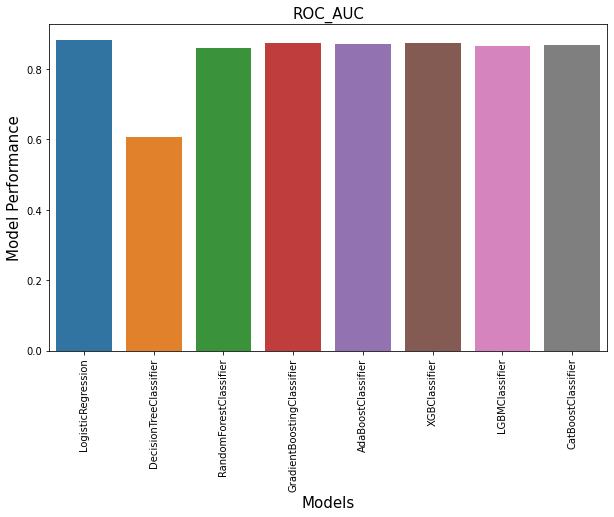

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.title('ROC_AUC', fontsize=15)
plt.show()

# 이러한 결과를 통해서 앙상블 모델 사용 시, XGB을 사용하도록 하자

## XGB + Optuna

- 파라미터 참고 : [sklearn.ensemble.GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [Using Optuna to Optimize XGBoost Hyperparameters](https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407)
- [AutoML? 야 너도 만들 수 있..을걸?](https://velog.io/@lazy_learner/AutoML-%EC%95%BC-%EB%84%88%EB%8F%84-%EB%A7%8C%EB%93%A4-%EC%88%98-%EC%9E%88%EC%96%B4#hyperparameters-optimization)

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [ ]:
sampler = TPESampler(seed=42)

def objectiveXGB(trial):

  param = {
  'max_depth':trial.suggest_int('max_depth',3,10),  
  'learning_rate': trial.suggest_float('learning_rate',0.01, 0.3),
  'n_estimators':trial.suggest_int('n_estimators',100, 2000),
  }

  model = XGBClassifier(**param)
  model.fit(X_train, y_train)
  pred = model.predict_proba(X_test)[:, 1]
  roc_auc = roc_auc_score(y_test, pred)
  return roc_auc

In [ ]:
studyGBM = optuna.create_study(direction='maximize',sampler=sampler)

# n_trials 지정
studyGBM.optimize(objectiveXGB, n_trials=100)

[I 2023-02-16 15:34:14,797] A new study created in memory with name: no-name-9b70b4f6-1cc4-419a-be0b-339cffadcd59
[I 2023-02-16 15:34:30,695] Trial 0 finished with value: 0.8571415297703114 and parameters: {'max_depth': 5, 'learning_rate': 0.28570714885887566, 'n_estimators': 1491}. Best is trial 0 with value: 0.8571415297703114.
[I 2023-02-16 15:34:37,244] Trial 1 finished with value: 0.8856618102529795 and parameters: {'max_depth': 7, 'learning_rate': 0.055245405728306586, 'n_estimators': 396}. Best is trial 1 with value: 0.8856618102529795.
[I 2023-02-16 15:34:45,273] Trial 2 finished with value: 0.8665124259768577 and parameters: {'max_depth': 3, 'learning_rate': 0.2611910822747312, 'n_estimators': 1242}. Best is trial 1 with value: 0.8856618102529795.
[I 2023-02-16 15:35:20,402] Trial 3 finished with value: 0.8814917366634456 and parameters: {'max_depth': 8, 'learning_rate': 0.01596950334578271, 'n_estimators': 1943}. Best is trial 1 with value: 0.8856618102529795.
[I 2023-02-16 1

In [ ]:
print('study.best_params:', studyGBM.best_trial.value)
print('Number of finished trials:', len(studyGBM.trials))
print('Best trial:', studyGBM.best_trial.params)

study.best_params: 0.898320077306177
Number of finished trials: 100
Best trial: {'max_depth': 3, 'learning_rate': 0.03351025594160962, 'n_estimators': 458}


In [ ]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(studyGBM)

In [ ]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(studyGBM)

In [ ]:
X.shape, X_test_df.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15553, 18), (3889, 18), (15553,), (11664, 18), (11664,), (3889, 18), (3889,))

In [ ]:
final_xgb_model = XGBClassifier(**studyGBM.best_params)
final_xgb_model.fit(X_train_df, y_train_df)

XGBClassifier(learning_rate=0.03351025594160962, n_estimators=458)

In [ ]:
sub_xgb_pred = final_xgb_model.predict_proba(X_test_df,validate_features=False)[:,1]
sub_xgb_pred 

array([0.00261835, 0.00982705, 0.00101534, ..., 0.00125486, 0.00215061,
       0.00081648], dtype=float32)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

preds = minmax.fit_transform(sub_xgb_pred.reshape(-1, 1))
preds.shape

(3889, 1)

In [ ]:
submission = pd.DataFrame({
    'id': np.arange(15304, 25508),
    'stroke': preds.reshape(-1, )
})
submission.head()

ValueError: ignored

In [ ]:
submission.to_csv('submission_xgb.csv', index=False )